## Preprocessing

In [9]:
import pandas as pd
import csv
import json

This project uses the dataset available at this Kaggle link, which contains English texts labeled with their corresponding CEFR levels, ranging from A1 to C2 :

https://www.kaggle.com/datasets/amontgomerie/cefr-levelled-english-texts/data

Let's check how many rows are present for each CEFR level.

In [10]:
df = pd.read_csv('datasets/cefr_leveled_texts.csv')
second_column = df.iloc[:, 1]
value_counts = second_column.value_counts()
print(value_counts)

label
A1    288
B2    286
A2    272
C1    241
B1    205
C2    202
Name: count, dtype: int64


Let's retrieve only 10 rows from each category and create a new dataset for training the model.

In [11]:
unique_values = df.iloc[:, 1].unique()
sampled_data = []

for value in unique_values:
    filtered_rows = df[df.iloc[:, 1] == value]
    sampled_data.append(filtered_rows.sample(n=10, random_state=41))

result_df = pd.concat(sampled_data)
result_df.to_csv('./datasets/cefr_60.csv', index=False)


# we also delete all the times we make a new line to ease the data processing
with open('./datasets/cefr_60.csv', 'r', newline='', encoding='utf-8') as infile:
    reader = csv.reader(infile)
    cleaned_data = [[cell.replace('\n', ' ').replace('\r', '') for cell in row] for row in reader]

with open('./datasets/cefr_60.csv', 'w', newline='', encoding='utf-8') as outfile:
    writer = csv.writer(outfile)
    writer.writerows(cleaned_data)

Let's check if it worked!

In [12]:
df_60 = pd.read_csv('datasets/cefr_60.csv')
second_column = df_60.iloc[:, 1]
value_counts = second_column.value_counts()
print(value_counts)

label
B2    10
A2    10
C1    10
B1    10
A1    10
C2    10
Name: count, dtype: int64


We add a new 'system' column (which contains the system message, providing context for the OpenAI model's response) to the CSV file and then convert it to JSONL format. This is the format required by OpenAI."

For more information, refer to the OpenAI guide. : 

https://platform.openai.com/docs/guides/fine-tuning#preparing-your-dataset

In [13]:
input_file = 'datasets/cefr_60.csv'

df = pd.read_csv(input_file, quotechar='"', encoding='utf-8', engine='python')

df['system'] = 'You are an AI model that evaluates the language proficiency of a given text according to the CEFR (Common European Framework of Reference for Languages). Please assess the level of the text and respond with one of the following options: A1, A2, B1, B2, C1, or C2. These are the only valid responses.'

df.to_csv(input_file, 
          index=False, 
          quoting=csv.QUOTE_ALL, 
          quotechar='"', 
          escapechar='\\',
          encoding='utf-8')

In [14]:
csv_file = 'datasets/cefr_60.csv'
jsonl_file = 'datasets/cefr_60.jsonl'

with open(csv_file, mode='r', encoding='utf-8') as infile, \
     open(jsonl_file, mode='w', encoding='utf-8') as outfile:

    reader = csv.DictReader(infile)
    
    for row in reader:
        messages = [
            {"role": "system", "content": row["system"]},
            {"role": "user", "content": row["text"]},
            {"role": "assistant", "content": row["label"]}
        ]
        json_line = json.dumps({"messages": messages}, ensure_ascii=False)
        outfile.write(json_line + "\n")

Now, let's create a dataset with 50 rows from each category to evaluate the performance of our models.

In [15]:
df = pd.read_csv('datasets/cefr_leveled_texts.csv')

other_df = pd.read_csv('datasets/cefr_60.csv')
exclude_ids = set(other_df.iloc[:, 0])

# we insure that no data from the verification data set is in the training dataset
filtered_df = df[~df.iloc[:, 0].isin(exclude_ids)]

grouped = filtered_df.groupby(df.columns[1], group_keys=False)
sampled_df = grouped.apply(lambda x: x.sample(n=50, random_state=42))

sampled_df.to_csv('datasets/cefr_verification.csv', index=False, quoting=csv.QUOTE_ALL, quotechar='"', escapechar='\\')

C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_6000\3038847861.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = grouped.apply(lambda x: x.sample(n=50, random_state=42))


In [16]:
df_verification = pd.read_csv('datasets/cefr_verification.csv')
second_column = df_verification.iloc[:, 1]
value_counts = second_column.value_counts()
print(value_counts)

label
A1    50
A2    50
B1    50
B2    50
C1    50
C2    50
Name: count, dtype: int64


## Training

Next, we can go to our OpenAI dashboard at this link and create a new fine-tuned model :

https://platform.openai.com/finetune

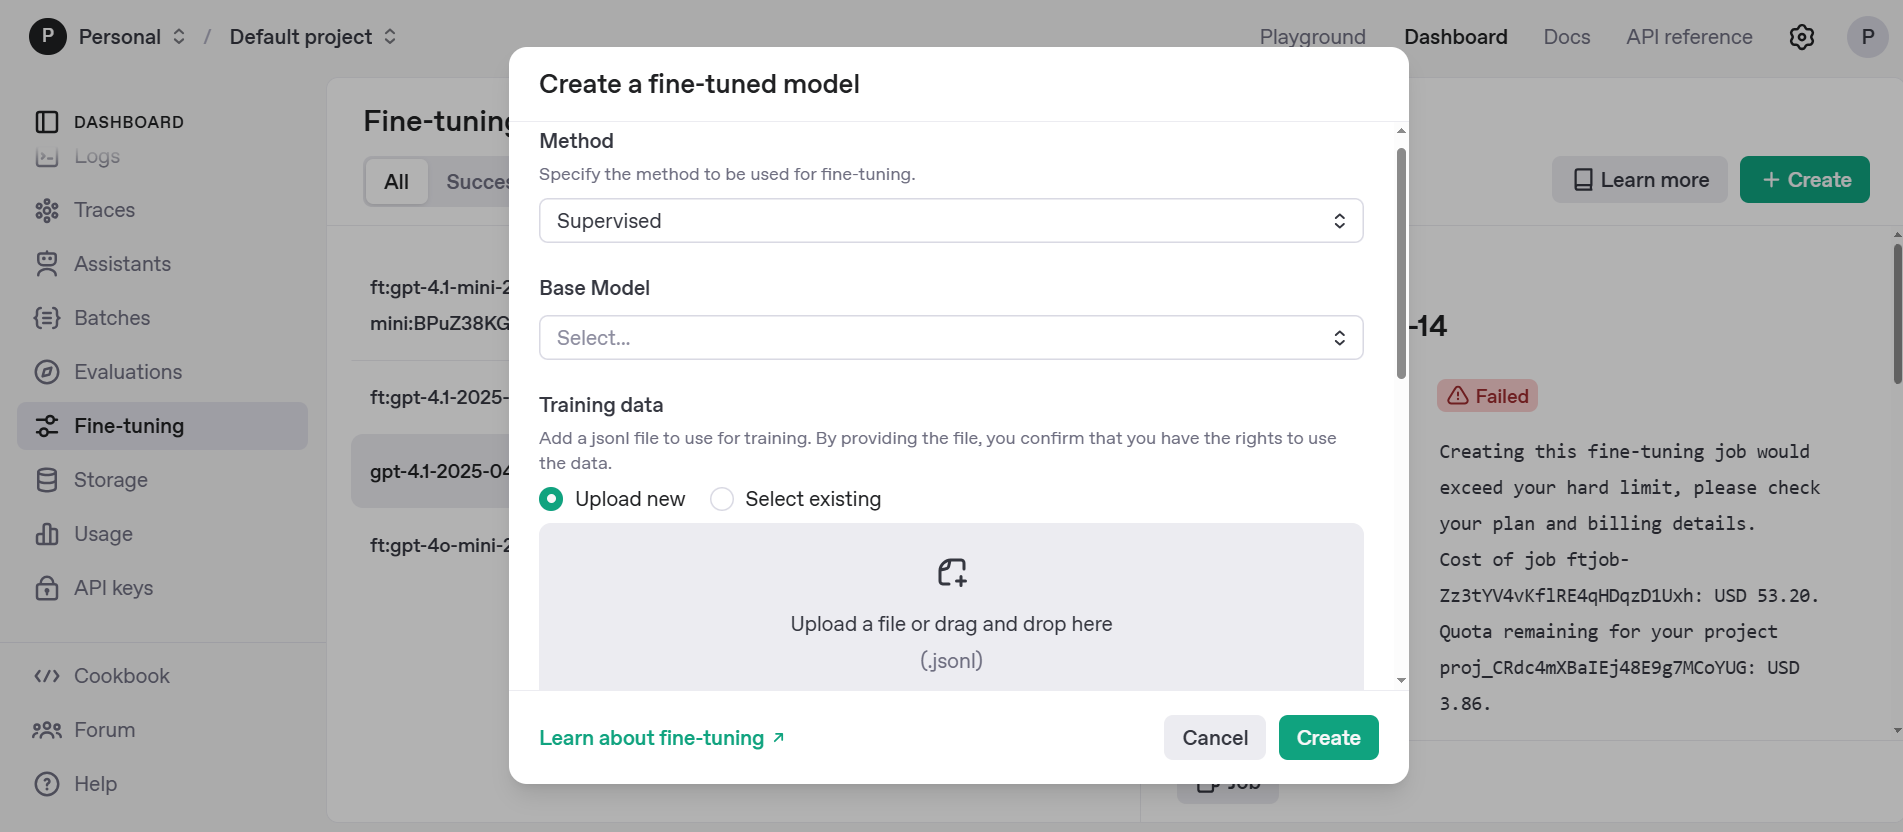



On the dashboard, we can select the model and the training data we just prepared.

We will fine-tune two models: gpt-4.1 and gpt-4.1-mini.

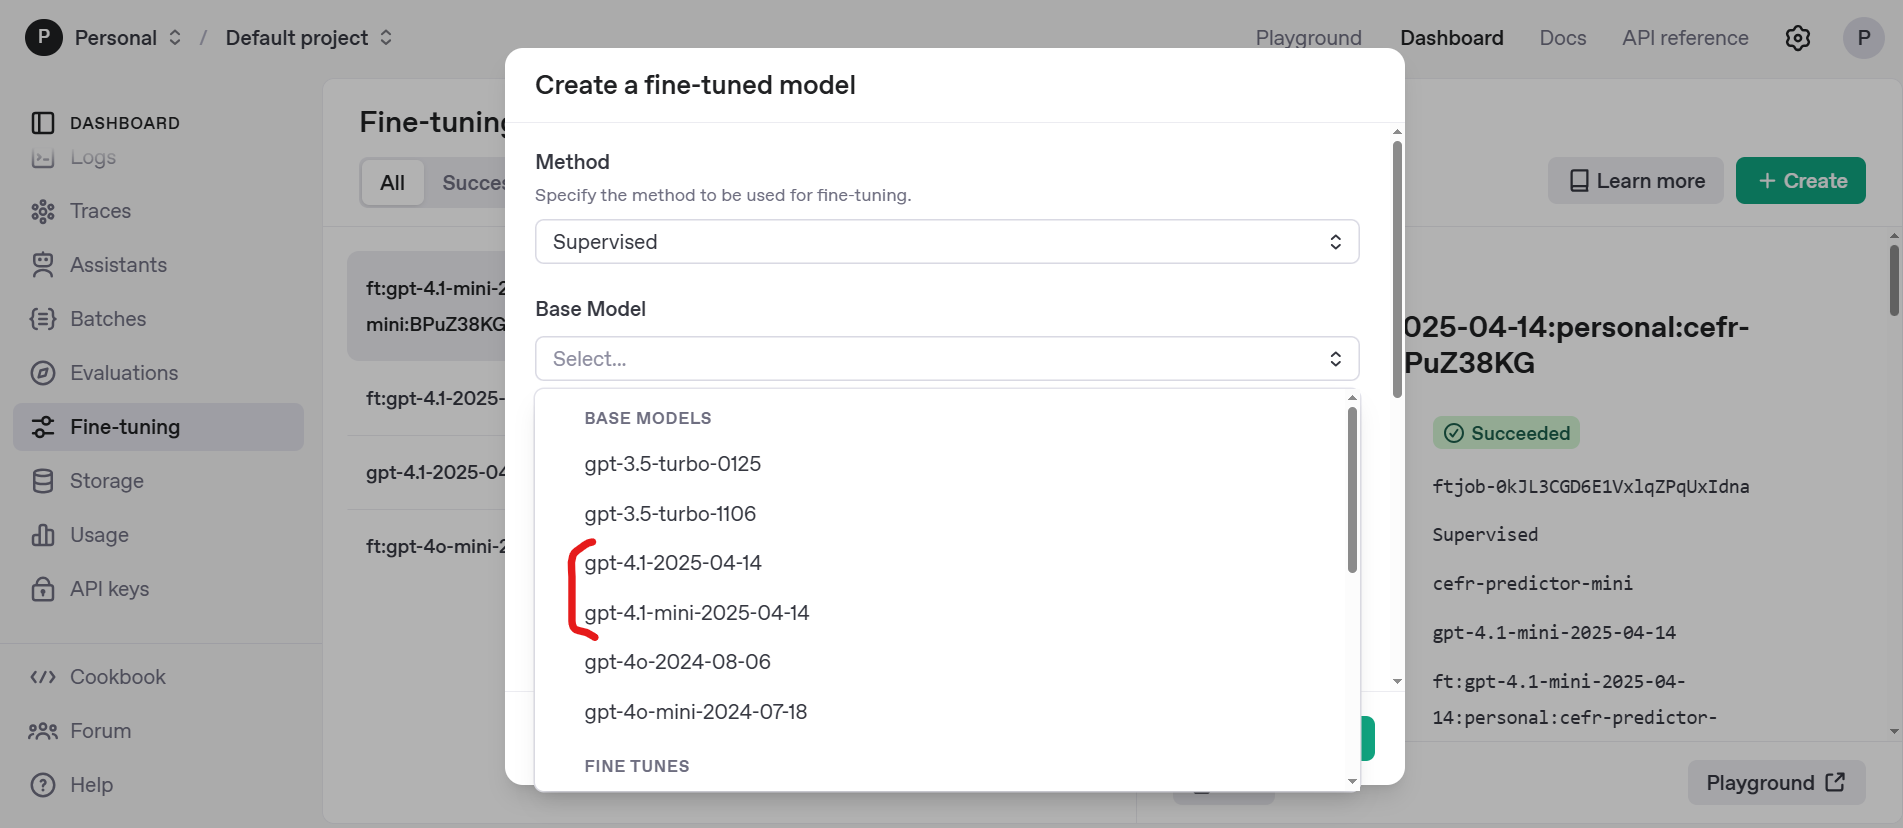



After the fine-tuning process is complete, we can see our two new models on the dashboard. We can now use them in our API calls.

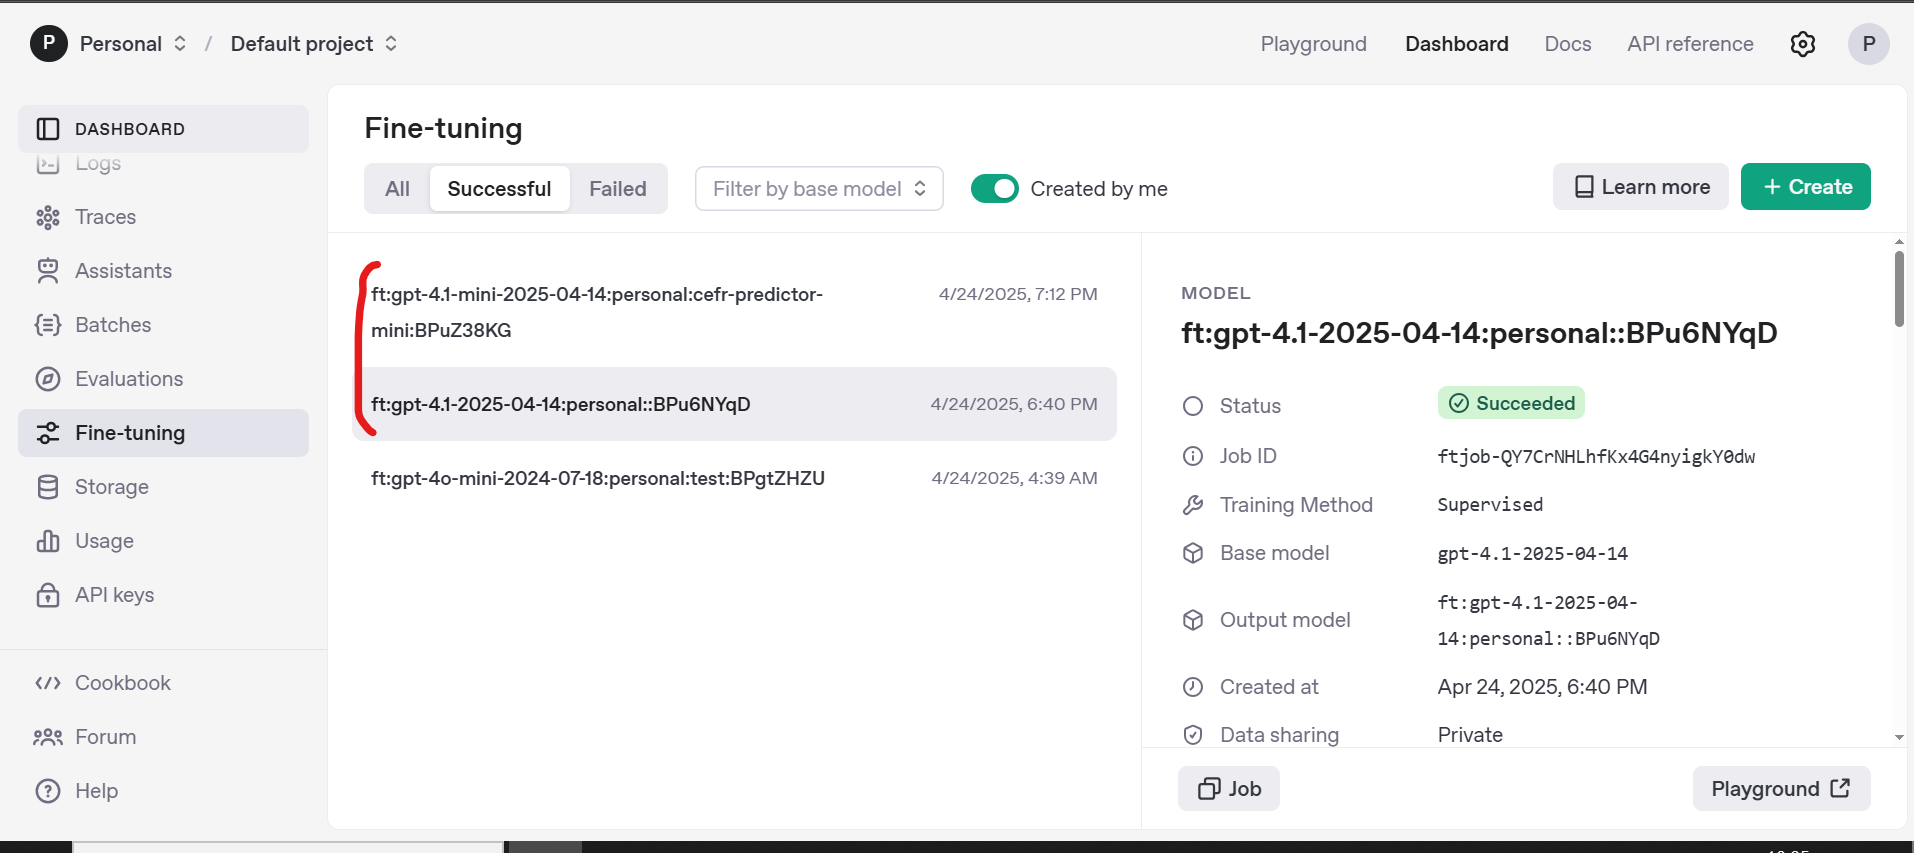

## Evaluation

Now that we have created two fine-tuned models, we can evaluate their performance using the validation dataset we created earlier and compare their results with the original models they were fine-tuned from. Thankfully, OpenAI provides a tool in the dashboard to simplify this process.

First, we click the 'Create' button on https://platform.openai.com/evaluations.

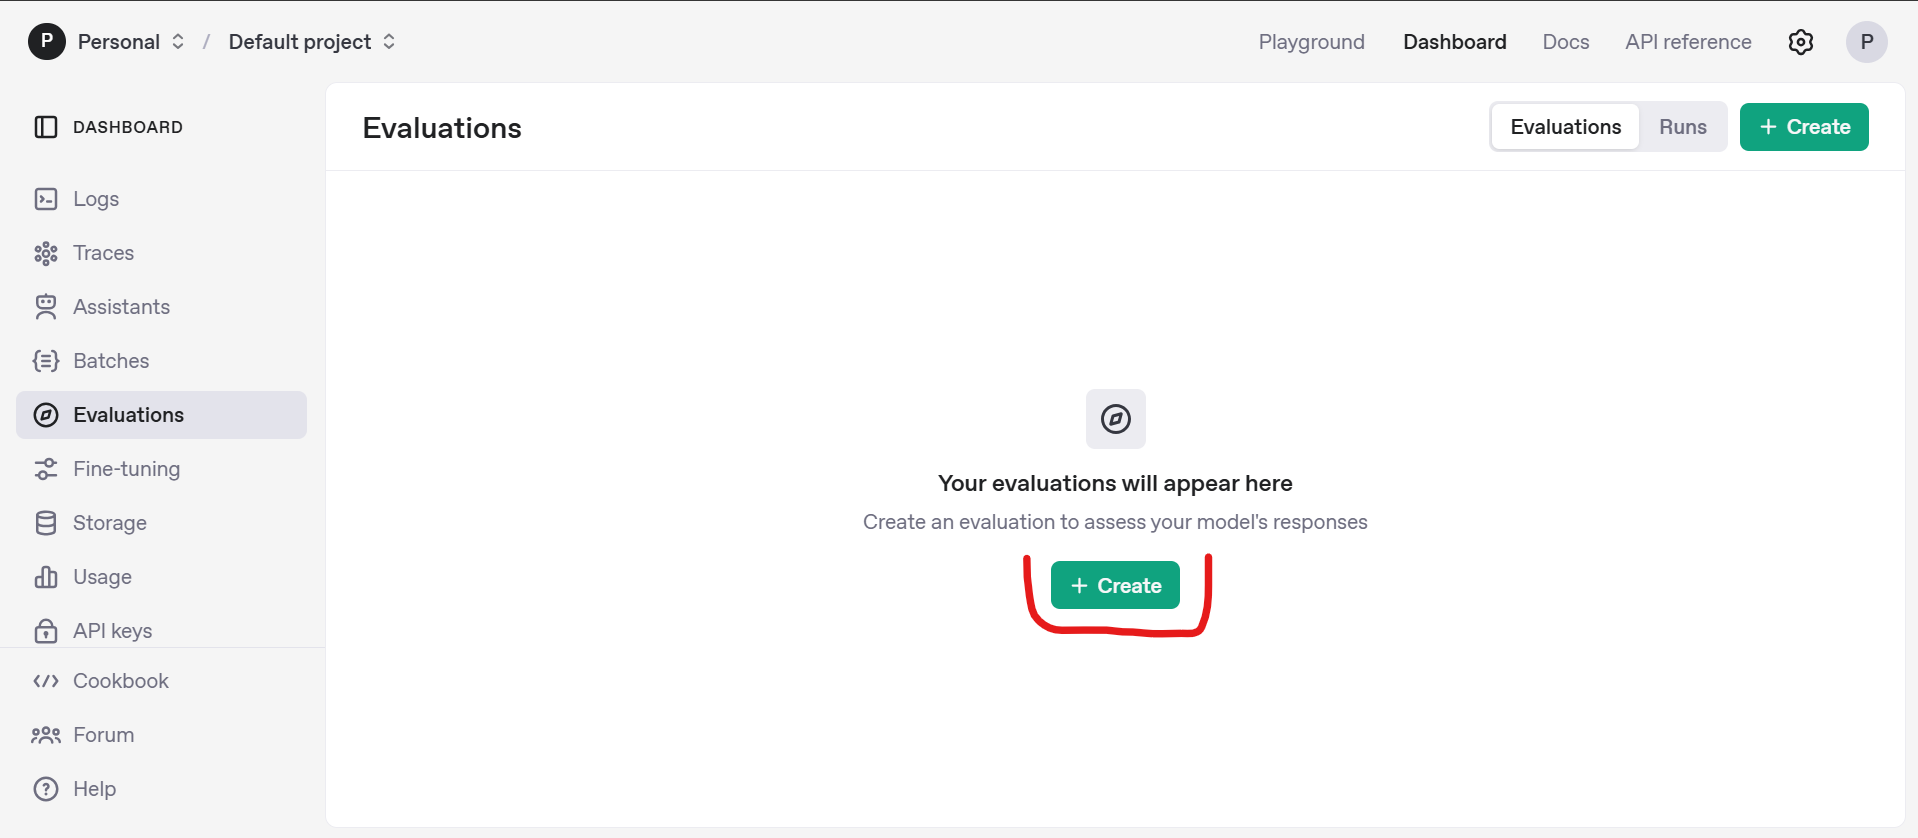



Next, we upload the validation dataset that we created earlier.

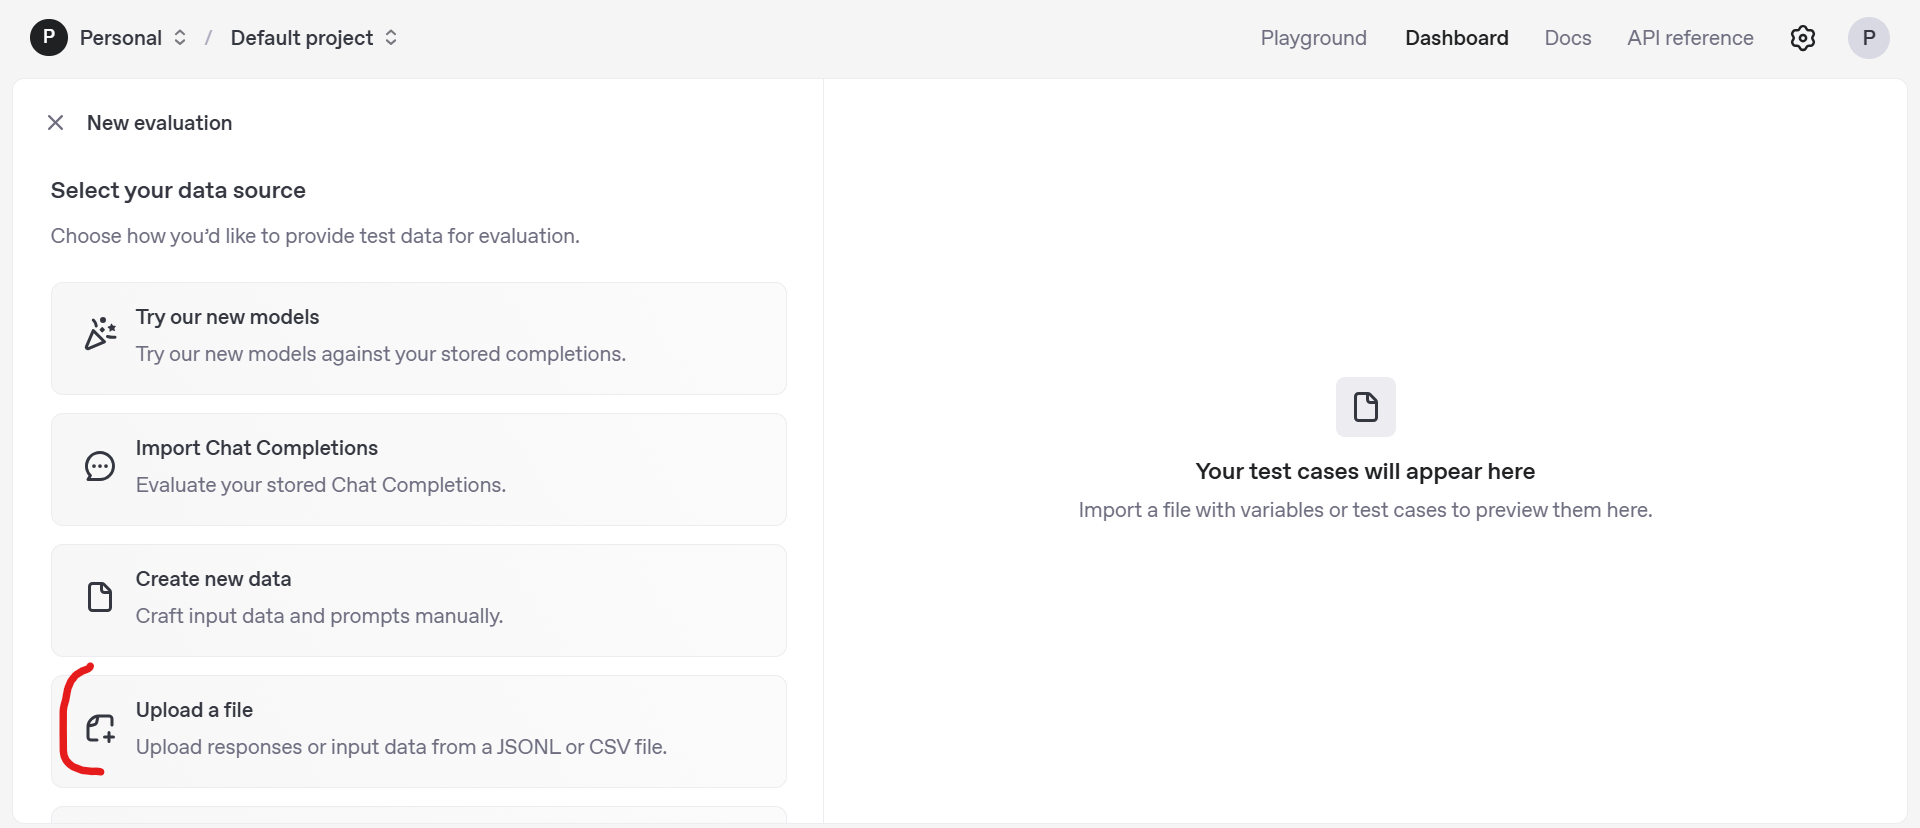



We can now see the uploaded data in a window. Take note of the column names.

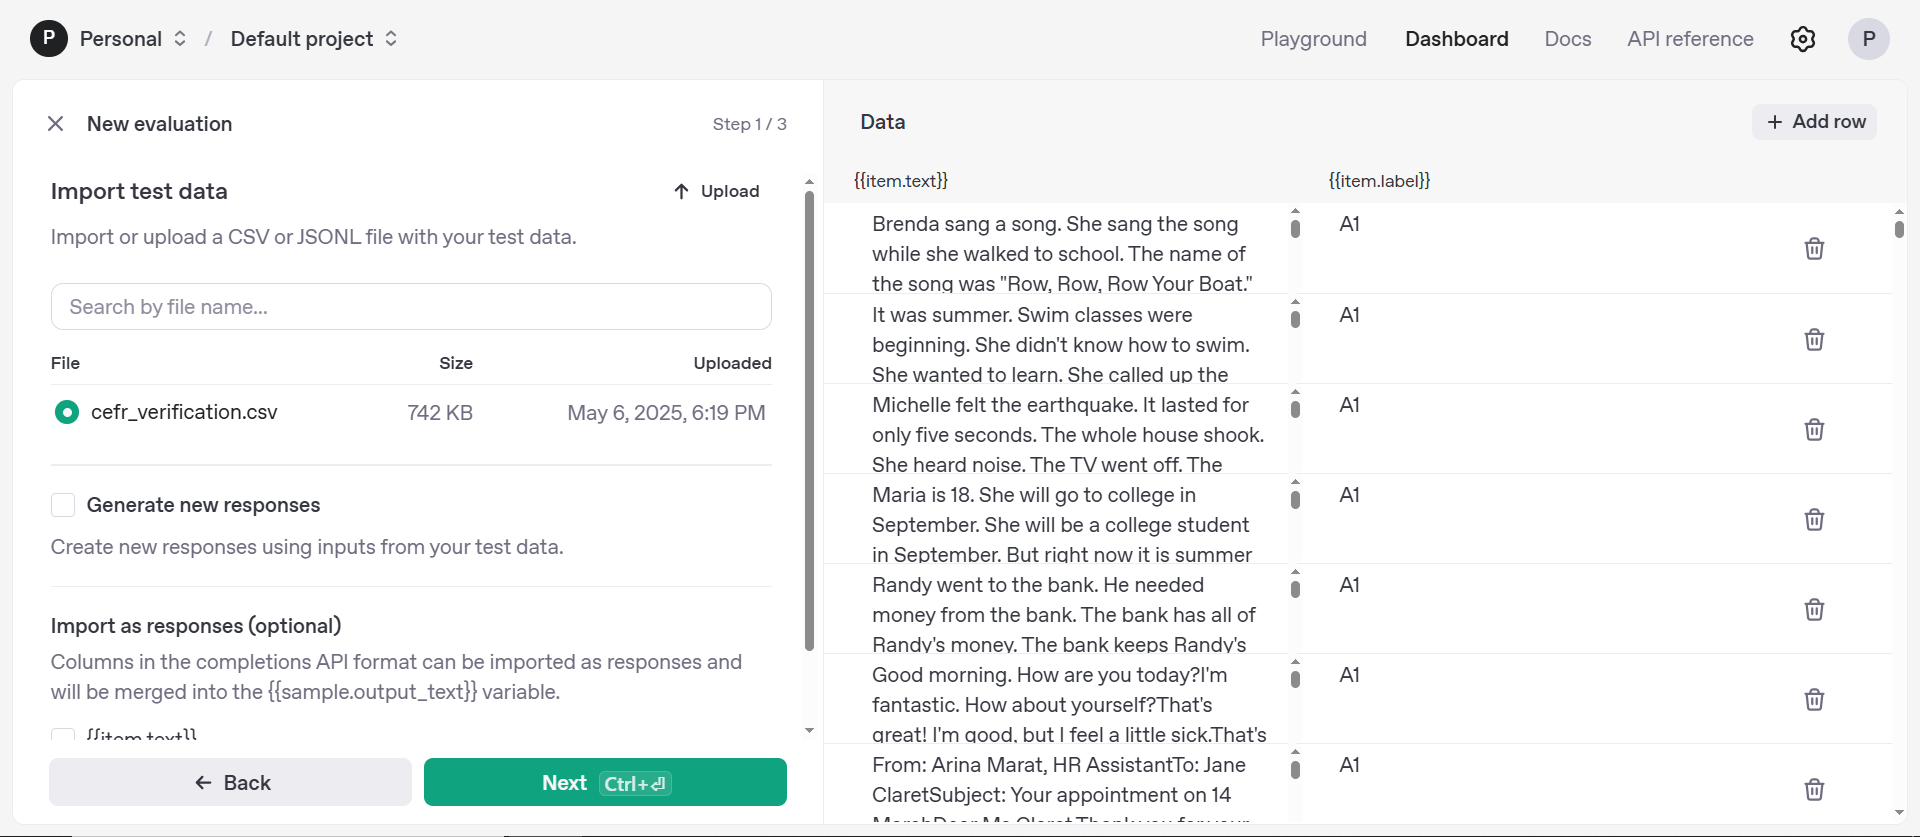



Now, we can create a run. We will simulate the response of each of the 4 models to the texts we provide. The model’s response will be one of the following values: A1, A2, B1, B2, C1, or C2.

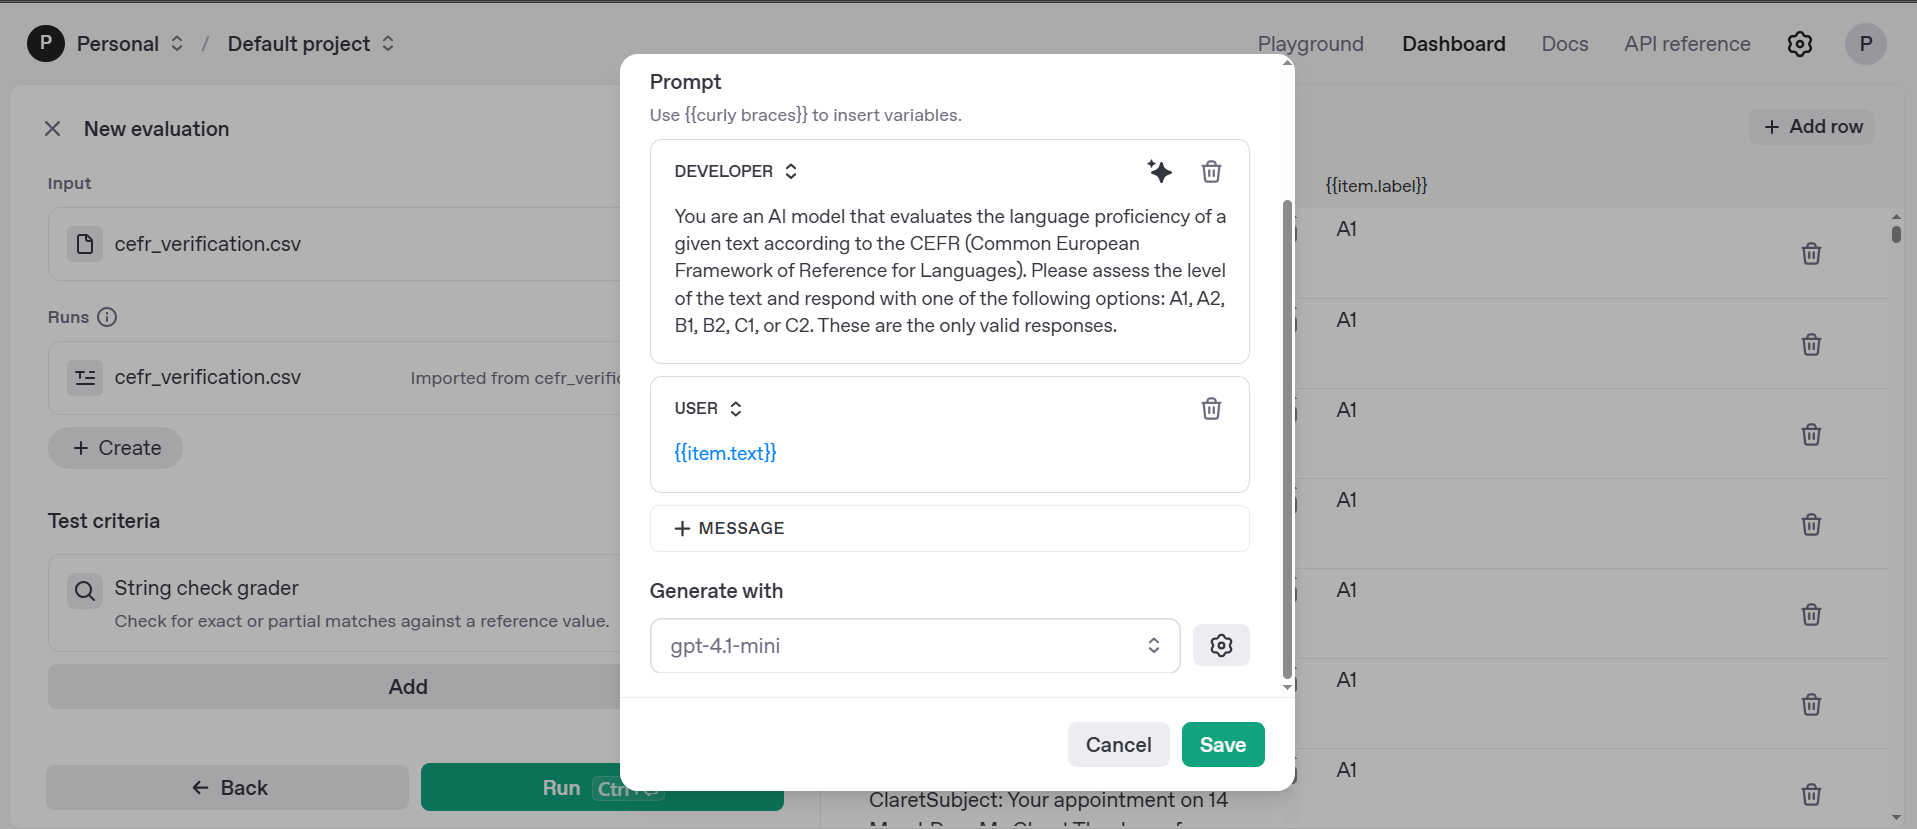



We also define the evaluation criteria: when the model's prediction matches the label of the text, it is considered a success.

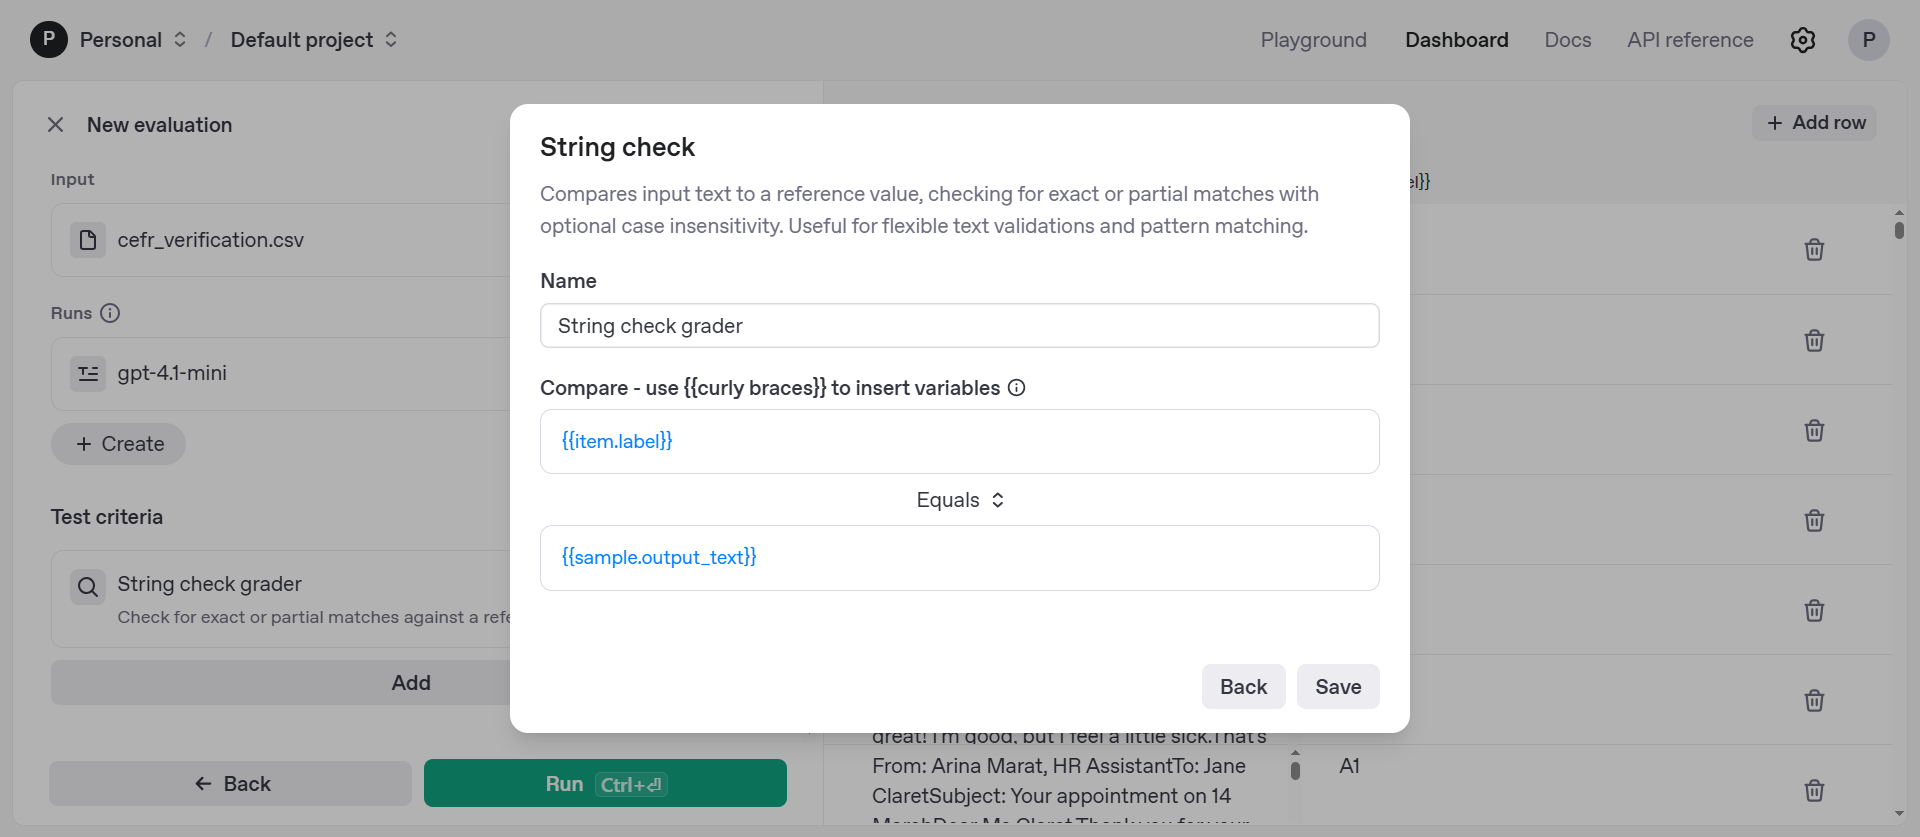



We can now see how well our 4 models performed.

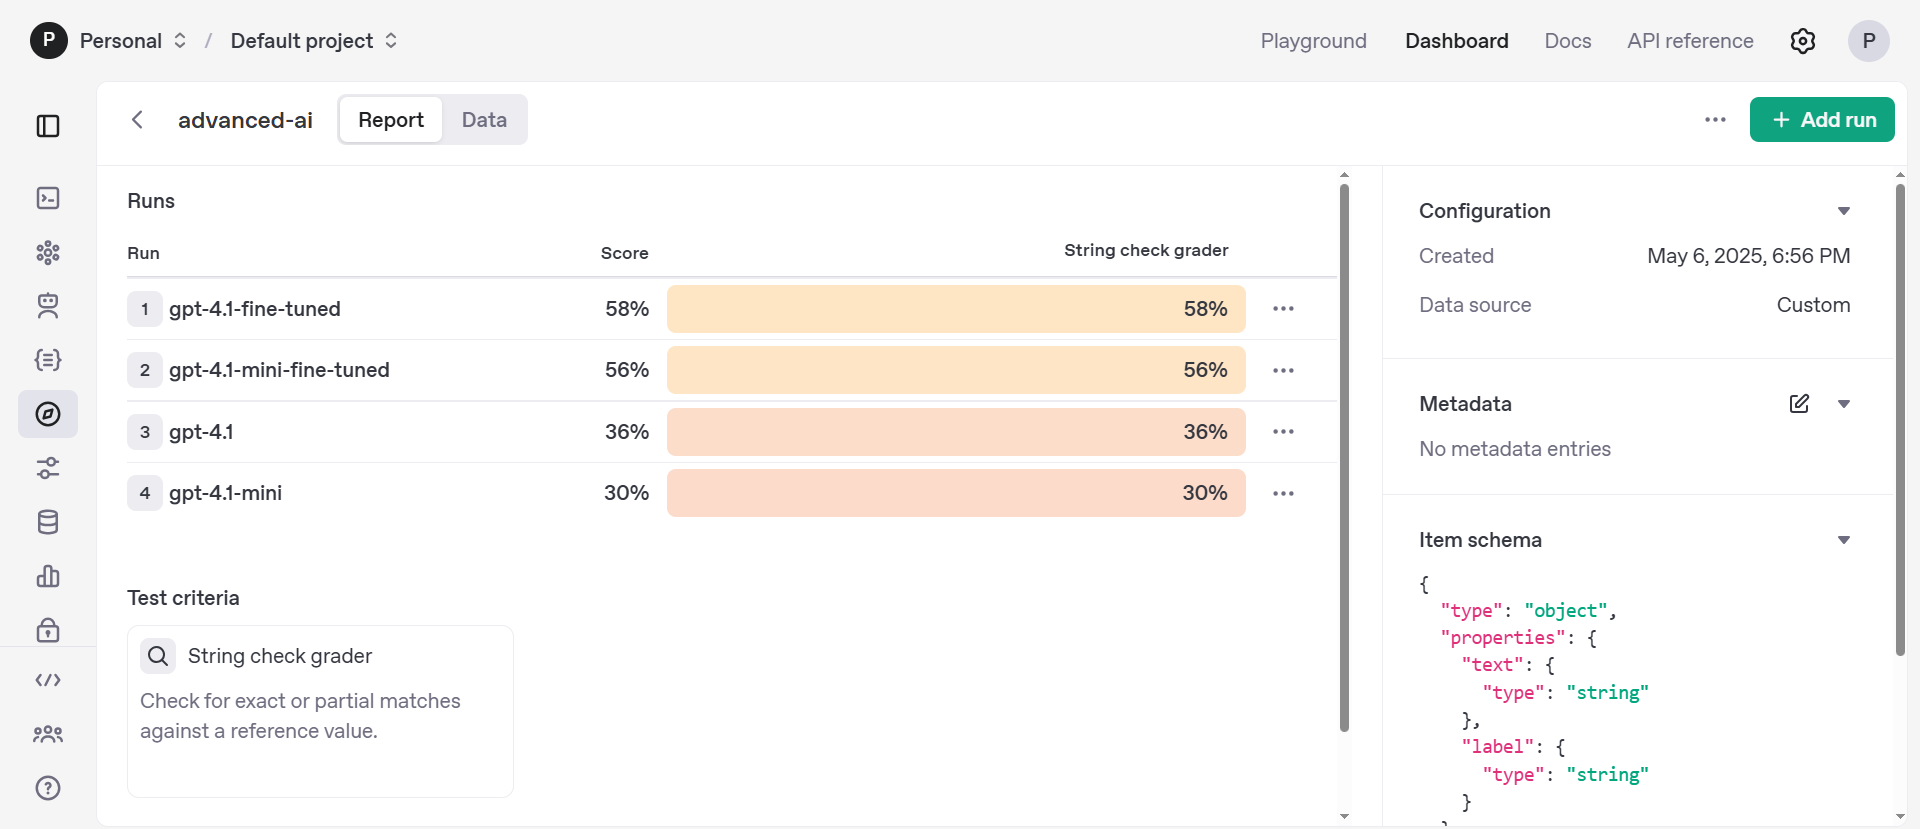